In [45]:
#!/usr/bin/env python3
# Copyright 2004-present Facebook. All Rights Reserved.
#  python optim.py -s example1/synth_test.json -e example1
import argparse
import json
import logging
import os
import random
import time
import torch
import numpy as np

import deep_sdf
import deep_sdf.workspace as ws

import pdb

from library.optimiser import *
from library.objective_function import *
from library.post_analysis import *
from library.experiments import *
%matplotlib notebook

In [3]:
def adjust_learning_rate(initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every):
    lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def chamfer_distance(p1, p2):
    '''
    Calculate Chamfer Distance between two point sets
    '''
    p1 = p1.unsqueeze(0)
    p2 = p2.unsqueeze(0)

    p1 = p1.repeat(p2.size(1), 1, 1)
    p1 = p1.transpose(0, 1)

    p2 = p2.repeat(p1.size(0), 1, 1)

    # compute distance tensor
    dist = torch.add(p1, torch.neg(p2))
    dist = torch.norm(dist, 2, dim=2)

    dist1, _ = torch.min(dist, dim = 1)
    dist2, _ = torch.min(dist, dim = 0)

    return torch.mean(dist1) + torch.mean(dist2)

class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 100
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False
args = argms()

In [20]:
def getLatentSourceAndTarget(args, source_id, target_id):
    # pick initialization and samples
    # Load collection of all latent codes
    all_codes_path = os.path.join(
        args.experiment_directory,
        ws.latent_codes_subdir,
        'latest.pth')
    all_codes = torch.load(all_codes_path)['latent_codes']['weight']
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    latent = all_codes[source_id].unsqueeze(0).detach()#.cuda()   #Add .cuda() if you want to run on GPU
    latent.requires_grad = True

    # This is be the target shape (ie objective)
    latent_target = all_codes[target_id].unsqueeze(0).detach()#.cuda()   #Add .cuda() if you want to run on GPU
    return latent, latent_target

def constructDecoder(args):
    specs_filename = os.path.join(args.experiment_directory, "specs.json")
    specs = json.load(open(specs_filename))
    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
    latent_size = specs["CodeLength"]
    # Load decoder: this is our black box function
    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(
        os.path.join(
            args.experiment_directory, ws.model_params_subdir, args.checkpoint + ".pth"
        ),
        map_location=torch.device('cpu') # Remove this if you want to run on GPU
    )
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    # Optionally: put decoder on GPU
    #decoder = decoder.module.cuda()
    return decoder

In [33]:
if __name__ == "__main__":
    
    torch.manual_seed(0)
    # 0 Initialization
    N_MARCHING_CUBE = 64
    lr= 8e-3
    l2reg= True
    regl2 = 1e-3
    decreased_by = 1.5
    adjust_lr_every = 50
    
    # 1 prepare data
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    ## torus
    target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
    latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
    
    # 2 prepare model
    decoder = constructDecoder(args)
    # 3 prepare optimiser
    optimizer = torch.optim.Adam([latent], lr=lr)

    losses = []
    lambdas = []
    

    objectiveDe = decoder_obj(latent_target, decoder)

    # Use Adam optimizer, with source as starting point, and a loss defined on meshes
    # latent is the input of our function
    print("Starting optimization:")
    for e in range(int(args.iterations)):
        print("latent: ", latent.detach().numpy())
        
        loss = objectiveDe.func(latent)
        losses.append(loss.detach().cpu().numpy()) 
        print("loss: ", loss.detach().numpy())
        
        grad = objectiveDe.dfunc(latent)
        print("latent grad: ", grad.detach().numpy())

        adjust_learning_rate(lr, optimizer, e, decreased_by, adjust_lr_every)
        optimizer.step()
        print(e, "th iteration\n")


Starting optimization:
latent:  [[-0.34123307 -0.47586045 -0.15240912  0.02312643  0.14862083  0.3323207
  -0.16005228 -0.12385195]]
loss:  0.48616672
latent grad:  [[-0.16347873 -0.13352345 -0.05753815  0.12673719  0.07140758  0.231334
  -0.00291534 -0.07419916]]
0 

latent:  [[-0.3332331  -0.46786046 -0.14440912  0.01512643  0.14062083  0.3243207
  -0.15205231 -0.11585195]]
loss:  0.4712739
latent grad:  [[-0.16055946 -0.13089393 -0.05674174  0.12418597  0.06993486  0.22692889
  -0.00313168 -0.0727852 ]]
1 

latent:  [[-0.32523718 -0.459865   -0.13641222  0.00713108  0.13262561  0.31632507
  -0.14404254 -0.10785633]]
loss:  0.45521456
latent grad:  [[-0.16372962 -0.1332162  -0.05807362  0.12634198  0.0711408   0.23114052
  -0.00341371 -0.0741118 ]]
2 

latent:  [[-0.3172369  -0.4518658  -0.12840982 -0.00086791  0.1246268   0.30832544
  -0.13601536 -0.09985678]]
loss:  0.44181013
latent grad:  [[-0.15954404 -0.12969825 -0.05668935  0.12298922  0.06929438  0.22518212
  -0.0033709  -0.0

loss:  0.2604891
latent grad:  [[ 0.04181341  0.03289808  0.01574708 -0.03084557 -0.0175534  -0.05701143
   0.00098496  0.01702858]]
33 

latent:  [[-0.1380441  -0.2725542   0.04958918 -0.18055451 -0.05605801  0.12878393
  -0.0569892   0.07920307]]
loss:  0.26129502
latent grad:  [[ 0.04391561  0.03400627  0.01696656 -0.03190156 -0.01830688 -0.05925058
   0.0007372   0.01723613]]
34 

latent:  [[-0.1379215  -0.27240548  0.04963903 -0.18072821 -0.0562568   0.12862037
  -0.05840074  0.07940324]]
loss:  0.2614028
latent grad:  [[ 0.04475055  0.03417282  0.01766839 -0.03207445 -0.01858371 -0.05981687
   0.00039827  0.01694653]]
35 

latent:  [[-0.13812964 -0.2725681   0.04932372 -0.18059094 -0.0561325   0.12877353
  -0.05975751  0.07931909]]
loss:  0.26128995
latent grad:  [[ 0.04466931  0.03395235  0.01773339 -0.03190605 -0.018556   -0.05956826
   0.00020468  0.01675194]]
36 

latent:  [[-0.13864076 -0.27301472  0.04867227 -0.18016964 -0.05571203  0.12921621
  -0.06103005  0.07897679]]
lo

loss:  0.25898927
latent grad:  [[-0.00331099 -0.0023856  -0.00133724  0.00238602  0.00145611  0.00460019
   0.00039158 -0.00120755]]
66 

latent:  [[-0.17029151 -0.30409804  0.01605857 -0.14942682 -0.02497533  0.1600567
  -0.08970461  0.04908768]]
loss:  0.2591815
latent grad:  [[-0.00362268 -0.00264025 -0.00144263  0.00263042  0.0015936   0.00504354
   0.00039645 -0.00134934]]
67 

latent:  [[-0.17050076 -0.30432406  0.01587699 -0.14920814 -0.02476692  0.16026577
  -0.09025974  0.04885614]]
loss:  0.25936636
latent grad:  [[-0.00399709 -0.0029519  -0.00156489  0.00293009  0.00175757  0.00558337
   0.00039555 -0.00153084]]
68 

latent:  [[-0.1706649  -0.30450594  0.01574094 -0.14903404 -0.0246038   0.1604301
  -0.0908273   0.04866777]]
loss:  0.25963962
latent grad:  [[-0.00408676 -0.00303441 -0.00158834  0.00300935  0.00180249  0.00572037
   0.00040031 -0.00157888]]
69 

latent:  [[-0.1707874  -0.30464697  0.01564681 -0.1489012  -0.02448262  0.16055302
  -0.09140734  0.04851939]]
los

loss:  0.2545965
latent grad:  [[-0.09966753  0.02435115 -0.12051886 -0.02227359  0.0149278   0.00657228
   0.05675548  0.10023019]]
99 



In [39]:
verts_target, faces_target = deep_sdf.mesh.create_mesh_optim(
    decoder, latent_target, N=N_MARCHING_CUBE, max_batch=int(2 ** 18)
)
if __name__ == "__main__":
    
    torch.manual_seed(0)
    # Initialization
    N_MARCHING_CUBE = 64
    lr= 8e-3
    l2reg= True
    regl2 = 1e-3
    decreased_by = 1.5
    adjust_lr_every = 50
    

    
    # pick initialization and samples
    # Load collection of all latent codes
    all_codes_path = os.path.join(
        args.experiment_directory,
        ws.latent_codes_subdir,
        'latest.pth')
    all_codes = torch.load(all_codes_path)['latent_codes']['weight']
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    latent = all_codes[source_id].unsqueeze(0).detach()#.cuda()   #Add .cuda() if you want to run on GPU
    latent.requires_grad = True

    ## torus
    target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4          # This is be the target shape (ie objective)
    latent_target = all_codes[target_id].unsqueeze(0).detach()#.cuda()   #Add .cuda() if you want to run on GPU

     
    
    specs_filename = os.path.join(args.experiment_directory, "specs.json")
    specs = json.load(open(specs_filename))
    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
    latent_size = specs["CodeLength"]
    # Load decoder: this is our black box function
    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(
        os.path.join(
            args.experiment_directory, ws.model_params_subdir, args.checkpoint + ".pth"
        ),
        map_location=torch.device('cpu') # Remove this if you want to run on GPU
    )
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    # Optionally: put decoder on GPU
    #decoder = decoder.module.cuda()


    optimizer = torch.optim.Adam([latent], lr=lr)

    losses2 = []
    lambdas = []
    
    objective = decoder_obj(latent_target, decoder)

    # Use Adam optimizer, with source as starting point, and a loss defined on meshes
    # latent is the input of our function
    print("Starting optimization:")
    for e in range(int(args.iterations)):

        if latent.grad is not None:
            latent.grad.detach_()
            latent.grad.zero_()

        verts, faces = deep_sdf.mesh.create_mesh_optim(decoder, latent, N=N_MARCHING_CUBE, max_batch=int(2 ** 18))

        
        # subsample vertices for gradients computations
        verts = verts[torch.randperm(verts.shape[0])]
        verts = verts[0:20000, :]
        # forward pass within loss layer
        xyz_upstream = torch.tensor(verts.astype(float), requires_grad = True, dtype=torch.float32)#, device=torch.device('cuda:0')) # For GPU,
        # Get a point cloud sampling of the target shape
        verts_target_sample = verts_target[torch.randperm(verts_target.shape[0])]
        verts_target_sample = verts_target_sample[0:20000, :]
        xyz_target = torch.tensor(verts_target_sample.astype(float), requires_grad = False, dtype=torch.float32) # For GPU, add: , device=torch.device('cuda:0'))
        # At this point we have 2 outputs for decoder: the target xyz_target, and the current value xyz_upstream
        # The following lines compute a loss and backpropagate
        # compute loss function: Chamfer between current guess (xyz_upstream) and objective (xyz_target)
        loss = chamfer_distance(xyz_upstream, xyz_target)
        print("Loss at iter", e, ":", loss.item(), ", latent norm: ", torch.norm(latent))
        
        
        losses2.append(loss.detach().cpu().numpy())                                  ## Loss value
        lambdas.append(torch.norm(latent_target-latent).detach().cpu().numpy())     ## Distance in the domain
        decoder.eval()
        loss.backward()
        dL_dx_i = xyz_upstream.grad
        
        # use vertices to compute full backward pass
        xyz = torch.tensor(verts.astype(float), requires_grad = True, dtype=torch.float32)#, device=torch.device('cuda:0')) # For GPU,
        latent_inputs = latent.expand(xyz.shape[0], -1)
        inputs = torch.cat([latent_inputs, xyz], 1)#.cuda()      #Add .cuda() if you want to run on GPU
        #first compute normals
        pred_sdf = decoder(inputs)
        loss_normals = torch.sum(pred_sdf)
        loss_normals.backward(retain_graph = True)
        normals = xyz.grad/torch.norm(xyz.grad, 2, 1).unsqueeze(-1)
        
        # now assemble inflow derivative
        latent.grad.detach_()
        latent.grad.zero_()
        dL_ds_i_fast = -torch.matmul(dL_dx_i.unsqueeze(1), normals.unsqueeze(-1)).squeeze(-1)
        loss_backward = torch.sum(dL_ds_i_fast * pred_sdf)
        if e % 20 == 0 and e > 0:
            regl2 = regl2/2
        if l2reg:
            loss_backward += regl2* torch.mean(latent.pow(2))
        # Backpropagate
        loss_backward.backward()

        
       # print("time to backward:", end-start)
        # update latent
        # Explicit gradient is accessible via latent.grad
        
        adjust_learning_rate(lr, optimizer, e, decreased_by, adjust_lr_every)
        optimizer.step()


        # 1. objective function value
        print("loss backward:", loss_backward.item())
        # 2. its derivative function value on current arguments 
        print("\n")
        #print(latent.grad)
        #print("shape of verts_target, faces_target: ", verts_target.shape, faces_target.shape, xyz_target.shape)
        #raise Exception("Stop");
        

Starting optimization:
Loss at iter 0 : 0.48616671562194824 , latent norm:  tensor(0.7349, grad_fn=<NormBackward0>)
loss backward: -0.00032093250774778426


Loss at iter 1 : 0.47127389907836914 , latent norm:  tensor(0.7159, grad_fn=<NormBackward0>)
loss backward: -0.0004450293490663171


Loss at iter 2 : 0.45521456003189087 , latent norm:  tensor(0.6971, grad_fn=<NormBackward0>)
loss backward: -0.0003503200423438102


Loss at iter 3 : 0.44181013107299805 , latent norm:  tensor(0.6785, grad_fn=<NormBackward0>)
loss backward: -0.00052491674432531


Loss at iter 4 : 0.4257057011127472 , latent norm:  tensor(0.6602, grad_fn=<NormBackward0>)
loss backward: -0.00047321445890702307


Loss at iter 5 : 0.4115152359008789 , latent norm:  tensor(0.6422, grad_fn=<NormBackward0>)
loss backward: -0.0005928690661676228


Loss at iter 6 : 0.39883702993392944 , latent norm:  tensor(0.6245, grad_fn=<NormBackward0>)
loss backward: -0.0005959018599241972


Loss at iter 7 : 0.3841349482536316 , latent nor

loss backward: 1.1138835361634847e-05


Loss at iter 62 : 0.25807440280914307 , latent norm:  tensor(0.4232, grad_fn=<NormBackward0>)
loss backward: 7.734292921668384e-06


Loss at iter 63 : 0.258292019367218 , latent norm:  tensor(0.4237, grad_fn=<NormBackward0>)
loss backward: 3.0643043373856926e-06


Loss at iter 64 : 0.2585563063621521 , latent norm:  tensor(0.4242, grad_fn=<NormBackward0>)
loss backward: -2.5317297058791155e-06


Loss at iter 65 : 0.25884777307510376 , latent norm:  tensor(0.4246, grad_fn=<NormBackward0>)
loss backward: -4.389380592328962e-06


Loss at iter 66 : 0.2589910924434662 , latent norm:  tensor(0.4251, grad_fn=<NormBackward0>)
loss backward: -5.21024094268796e-06


Loss at iter 67 : 0.25918376445770264 , latent norm:  tensor(0.4254, grad_fn=<NormBackward0>)
loss backward: -6.157760253699962e-06


Loss at iter 68 : 0.2593681216239929 , latent norm:  tensor(0.4258, grad_fn=<NormBackward0>)
loss backward: -9.01718158274889e-06


Loss at iter 69 : 0.259641319

<IPython.core.display.Javascript object>


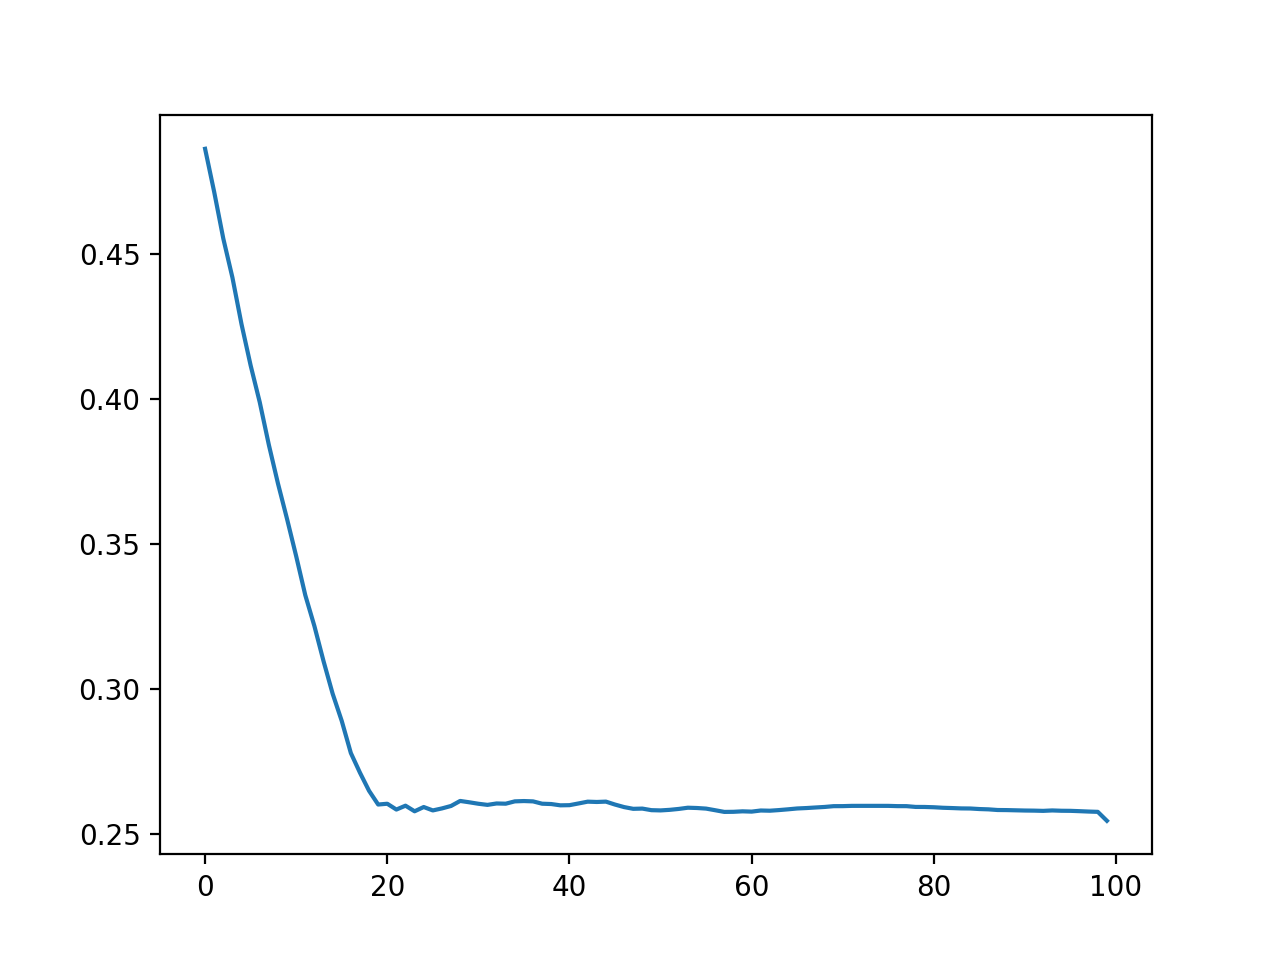

In [35]:
plt.plot(losses)

<IPython.core.display.Javascript object>


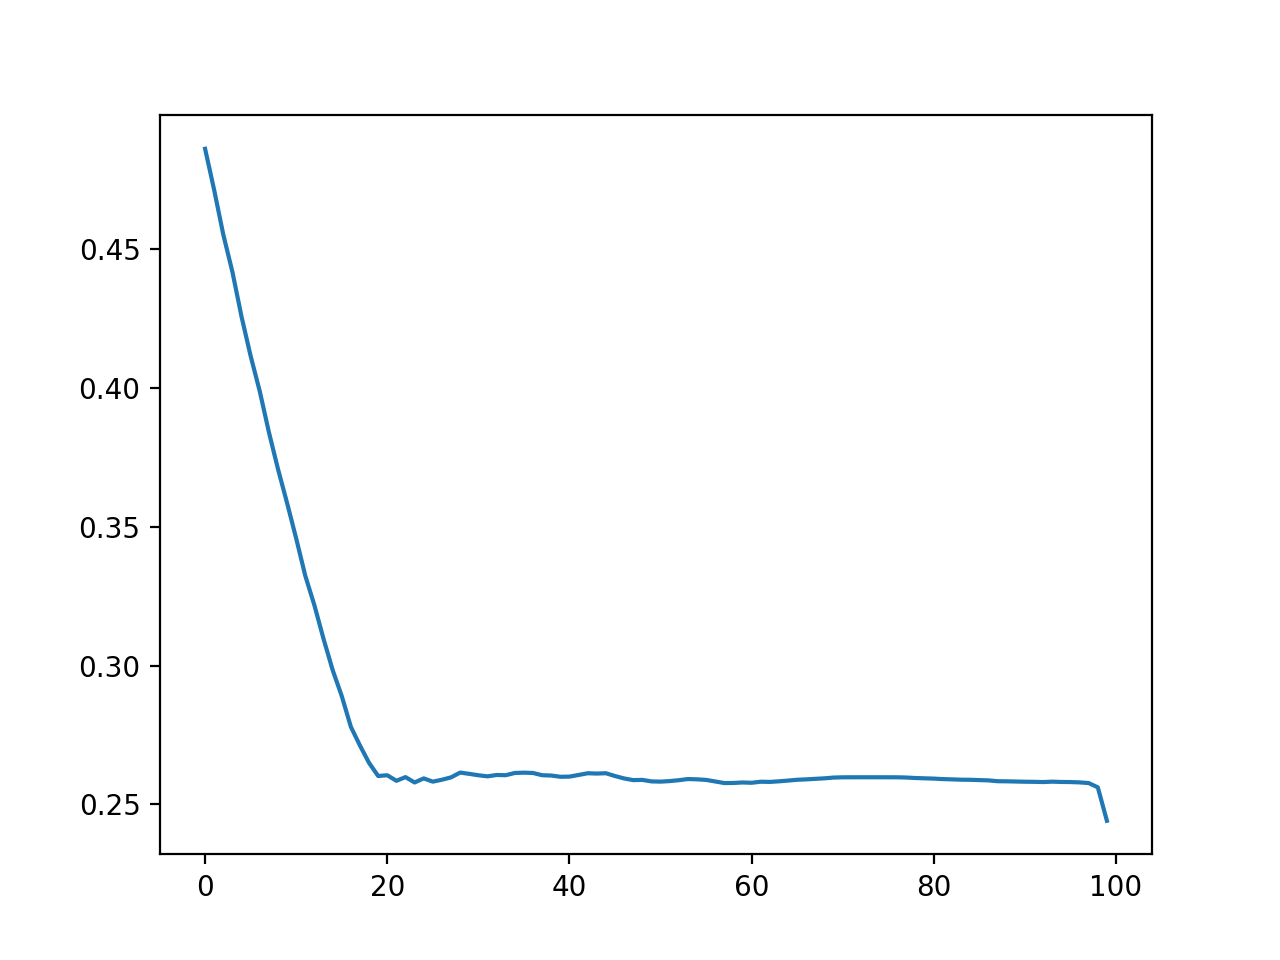

In [41]:
plt.plot(losses2)

In [51]:
class cma_es(adjust_optimizer):
    def __init__(self, dim=2):
        self.dim = dim
        paras = {'x0': torch.zeros((dim,)),
                 'std': torch.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': do_nothing(), 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + torch.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)).int()
            return (1 - cc) * pc + hsig * torch.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < (1.4 + 2/(dim + 1))).int()
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ torch.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * torch.exp((cs / damps) * (torch.norm(ps)/ chiN - 1))
        def is_not_moving(arg, val, pre_arg, pre_val, tol):
            dis_arg = torch.norm(arg - pre_arg, dim=1).mean()
            dis_val = torch.abs(val - pre_val).mean()
            return (dis_arg < tol and dis_val < tol) 

        if self.verbose:
            print("\n\n*******starting optimisation from intitial mean: ", self.x0.squeeze().detach().numpy())
        # User defined input parameters 
        dim = self.dim
        sigma = 0.3
        D = self.std / sigma
        mean = self.x0.reshape(dim, 1)
        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = np.log(mu + 1/2) - torch.log(torch.arange(mu, dtype=torch.float) + 1) 
        weights = (weights / torch.sum(weights)).float()    
        mueff = 1 / torch.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs                                                                 

        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = torch.zeros((dim, 1))     
        ps = torch.zeros((dim, 1)) 
        # B defines the coordinate system
        B = torch.eye(int(dim))       
        # covariance matrix C
        C = B * torch.diag(D**2) * B.T 
        # C^-1/2 
        invsqrtC = B * torch.diag(D**-1) * B.T   
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, f = torch.zeros((lambda_, dim)), torch.zeros((lambda_, dim)), torch.zeros((lambda_,))
        stats = {}
        inner_stats = {}
        stats['inner'] = []
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals_per_iter'] = torch.zeros((lambda_, )), []
        inner_stats = [{}] * lambda_
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0
        # initial data in record
        for i in range(lambda_):
            x[i,:] = (mean + torch.randn(dim, 1)).squeeze()
            f[i] = obj.func(x[i])
        idx = torch.argsort(f.detach())
        x_ascending = x[idx]
        if self.record:
            stats['inner'].append(inner_stats.detach().numpy())
            stats['arg'].append(x_ascending.detach().numpy())
            stats['val'].append(f[idx].detach().numpy())
            stats['mean'].append(mean.detach().numpy())
            stats['std'].append(sigma * B @ torch.diag(D))
            stats['evals_per_iter'].append(torch.ones((lambda_,)).detach().numpy())
            stats['x_adjust'].append(np.vstack((x.T.clone().detach().numpy(), x.T.clone().detach().numpy())))
        arg = x_ascending
        val = f[idx]
        pre_arg = x_ascending
        pre_val = f[idx]
        best_val = 1e4
        best_arg = None
        
        # optimise by iterations
        try:
            while iter_ < self.max_iter:
                iter_ += 1
                # generate candidate solutions with some stochastic elements
                for i in range(lambda_):
                    x[i] = (mean + sigma * B @ torch.diag(D) @ torch.randn(dim, 1)).squeeze()
                    x_old[i] = x[i]
                    x[i], f[i], inner_stats[i] = self.adjust_func.adjust(x[i].clone().detach().requires_grad_(True), obj)
                    eval_ += inner_stats[i]['evals']
                    iter_eval[i] = inner_stats[i]['evals']
                # sort the value and positions of solutions 
                idx = torch.argsort(f.detach())
                x_ascending = x[idx]

                # update the parameter for next iteration
                mean_old = mean
                mean = update_mean(x_ascending[:mu])
                ps =   update_ps(ps, sigma, C, mean, mean_old)
                pc =   update_pc(pc, sigma, ps, mean, mean_old)
                sigma = update_sigma(sigma, ps)
                C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
                C = torch.triu(C) + torch.triu(C, 1).T
                D, B = torch.eig(C, eigenvectors=True)
                D = torch.sqrt(D[:,0])
                invsqrtC = B @ torch.diag(D**-1) @ B

                # record data during process for post analysis
                if self.record:
                    stats['inner'].append(inner_stats.clone().detach().numpy())
                    stats['arg'].append(x_ascending.detach().numpy())
                    stats['val'].append(f[idx].detach().numpy())
                    stats['mean'].append(mean.detach().numpy())
                    stats['std'].append((sigma * B @ np.diag(D)).detach().numpy())
                    stats['evals_per_iter'].append(iter_eval.clone().detach().numpy())
                    stats['x_adjust'].append(np.vstack((x_old.T.clone().detach().numpy(), x.T.clone().detach().numpy())))
                # stopping condition    
                arg = x_ascending
                val = f[idx]
                if best_val > val[0]:
                    best_val = val[0]
                    best_arg = arg[0]              
                # check the stop condition
                if torch.max(D) > (torch.min(D) * 1e6):
                    stats['status'] = 'diverge'
                    print('diverge, concentrate in low dimension manifold')
                    break
                if is_not_moving(arg, val, pre_arg, pre_val, self.tol) :
                    break
                pre_arg = arg
                pre_val = val
        except np.linalg.LinAlgError as err:
            stats['status'] = 'diverge'
            print('diverge, raise LinAlgError!')
        finally:
            if self.verbose:
                print('eigenvalue of variance = {}'.format(D))
                print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
                print('found minimum position = {}, found minimum = {}'.format(best_arg.detach().numpy(), best_val.detach().numpy()))

        # carry statistics info before quit
        if self.record:
            stats['arg'] = np.array(stats['arg'])
            stats['val'] = np.array(stats['val'])
            stats['mean'] = np.array(stats['mean'])
            stats['std'] = np.array(stats['std'])
            stats['evals_per_iter'] = np.array(stats['evals_per_iter'])
            stats['x_adjust'] = np.array(stats['x_adjust'])
        stats['evals'] = eval_
        return best_arg, best_val, stats

In [57]:
class decoder_obj(objective_func):
    def __init__(self, latent_target, decoder):
        self.N_MARCHING_CUBE = 64
        self.l2reg= True
        self.regl2 = 1e-3
        self.iter = 0
        self.quick = False
        
        self.latent_target = latent_target
        self.decoder = decoder
        self.optimum = 0
        self.optimal = latent_target
        
        # Get a mesh representation of the target shape
        self.verts_target, faces_target = deep_sdf.mesh.create_mesh_optim(
            decoder, latent_target, N=self.N_MARCHING_CUBE, max_batch=int(2 ** 18)
        )
    
        
    def func(self, latent):
        # from latent to xyz
        verts, faces = deep_sdf.mesh.create_mesh_optim(self.decoder, latent, N=self.N_MARCHING_CUBE, max_batch=int(2 ** 18))
        verts = verts[torch.randperm(verts.shape[0])]
        verts = verts[0:20000, :]
        self.xyz_upstream = torch.tensor(verts.astype(float), requires_grad = True, dtype=torch.float32)#, device=torch.device('cuda:0')) # For GPU,
       
        # from latent_traget to xyz_target
        verts_target_sample = self.verts_target[torch.randperm(self.verts_target.shape[0])]
        verts_target_sample = verts_target_sample[0:20000, :]
        xyz_target = torch.tensor(verts_target_sample.astype(float), requires_grad = False, dtype=torch.float32) # For GPU, add: , device=torch.device('cuda:0'))

        # compare difference
        loss = chamfer_distance(self.xyz_upstream, xyz_target)
        self.last_loss = loss;
        self.last_latent = latent;
        return loss
    
    def dfunc(self, latent):
        
        if latent.grad is not None:
            latent.grad.detach_()
            latent.grad.zero_()
        
        # step 1
        if self.quick and torch.norm(latent - self.last_latent):
            loss = self.last_loss
        else:
            loss = self.func(latent)
        decoder.eval()
        loss.backward()
        dL_dx_i = self.xyz_upstream.grad
        
        # step 2
        # use vertices to compute full backward pass
        xyz = self.xyz_upstream.clone().detach()
        xyz.requires_grad = True
        latent_inputs = latent.expand(xyz.shape[0], -1)
        inputs = torch.cat([latent_inputs, xyz], 1)#.cuda()      #Add .cuda() if you want to run on GPU
        #first compute normals
        pred_sdf = self.decoder(inputs)
        loss_normals = torch.sum(pred_sdf)
        loss_normals.backward(retain_graph = True)
        normals = xyz.grad/torch.norm(xyz.grad, 2, 1).unsqueeze(-1)
                
        # step 3
        # now assemble inflow derivative
        latent.grad.detach_()
        latent.grad.zero_()
        dL_ds_i_fast = -torch.matmul(dL_dx_i.unsqueeze(1), normals.unsqueeze(-1)).squeeze(-1)
        loss_backward = torch.sum(dL_ds_i_fast * pred_sdf)
        if l2reg and self.iter % 20 == 0 and self.iter > 0:
            self.regl2 = self.regl2/2
        if l2reg:
            loss_backward += self.regl2 * torch.mean(latent.pow(2))
        # Backpropagate
        loss_backward.backward()
        
        return latent.grad
        

In [69]:
class adam(adjust_optimizer):
    def __init__(self, alpha=0.01, verbose=False, dim=2):
        self.alpha = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-11
        self.max_iter = 10000
        self.tol = 1e-3
        self.verbose = verbose
        self.record = False
        self.x0 = torch.zeros((dim,))
        
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta_1 = paras['beta_1']
        self.beta_2 = paras['beta_2']
        self.epsilon = paras['epsilon']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
        self.record = False if 'record' not in paras.keys() else paras['record']
        
    def optimise(self, obj):
        m_t = 0 
        v_t = 0 
        eval_cnt = 0
        x = self.x0
        stats = {}
        stats['status'] = None
        stats['gradient_before_after'] = []
        stats['arg'] = []
        stats['val'] = []
        if self.record:
            stats['arg'].append(x.clone().detach().numpy())
            stats['val'].append(obj.func(x).detach().numpy())
            stats['gradient_before_after'].append([obj.dfunc(x).detach().numpy(), obj.dfunc(x).detach().numpy()])
        if self.verbose:
            print("\n\n*******starting optimisation from intitial point: ", self.x0.squeeze().detach().numpy())
        while eval_cnt < self.max_iter:					#till it gets converged
            eval_cnt += 1
            x = x.clone().detach().requires_grad_(True)
            loss = obj.func(x)
            g_t = obj.dfunc(x)		#computes the gradient of the stochastic function
            m_t = self.beta_1*m_t + (1-self.beta_1)*g_t	#updates the moving averages of the gradient
            v_t = self.beta_2*v_t + (1-self.beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(self.beta_1**eval_cnt))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(self.beta_2**eval_cnt))		#calculates the bias-corrected estimates
            x_prev = x.clone()								
            est_df = (m_cap)/(torch.sqrt(v_cap)+self.epsilon)
            with torch.no_grad():
                x -= self.alpha * est_df 	#updates the parameters
            if self.verbose:
                print("iter: ", eval_cnt)
                print("loss: ", loss.detach().numpy())
                print("gradient: ", g_t.detach().numpy())
                print("latent: ", x.detach().numpy())
                print("\n")
            if self.record:
                stats['arg'].append(x.clone().detach().numpy())
                stats['val'].append(obj.func(x).detach().numpy())
                stats['gradient_before_after'].append([g_t.detach().numpy(), est_df.detach().numpy()])
            if(torch.norm(x-x_prev) < self.tol):		#checks if it is converged or not
                break
        if self.verbose:
            print('total evaluatios = {}'.format(eval_cnt))
            print('gradient at stop position = {},\nmodified graident = {}'.format(g_t, est_df))
            print('found minimum position = {}, found minimum = {}'.format(x.detach().numpy(), obj.func(x).detach().numpy()))
        stats['arg'] = np.array(stats['arg'])
        stats['val'] = np.array(stats['val'])
        stats['gradient_before_after'] = np.array(stats['gradient_before_after'])
        stats['evals'] = eval_cnt
        return x, obj.func(x), stats
    
class line_search(adjust_optimizer):
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
        self.verbose = False
        self.record = False
     
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
        self.record = True if 'record' not in paras.keys() else paras['record']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 3
        stats = {}
        stats['status'] = None
        stats['gradient'] = []
        stats['arg'] = []
        stats['val'] = []
        if self.record:
            stats['arg'].append(x.clone().detach().numpy())
            stats['val'].append(fx.detach().numpy())
            stats['gradient'].append(-p.detach().numpy())
        if self.verbose:
            print("\n*******starting optimisation from intitial point: ", self.x0.squeeze().detach().numpy())
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            with torch.no_grad():
                x += alpha_ * p
            fx = fnx
            x = x.clone().detach().requires_grad_(True)
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if self.record:
                stats['arg'].append(x.clone().detach().numpy())
                #print(eval_cnt, stats['arg'])
                stats['val'].append(fx.detach().numpy())
                stats['gradient'].append(-p.detach().numpy())
            if torch.norm(p) < self.tol:
                break
        stats['evals'] = eval_cnt
        if self.verbose:
            print('total evaluatios = {}'.format(eval_cnt))
            print('gradient at stop position = {}'.format(-p.detach().numpy()))
            print('found minimum position = {}, found minimum = {}'.format(x.detach().numpy(), fx.detach().numpy()))
        stats['arg'] = np.array(stats['arg'])
        stats['val'] = np.array(stats['val'])
        stats['gradient'] = np.array(stats['gradient'])
        return x, fnx, stats



In [70]:
# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 0.001,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 100,
         'tol': 1e-6,              
         'verbose': True,
         'record': False }
opt.set_parameters(optParas)
exp.set_optimizer(opt)
exp.do()



*******starting optimisation from intitial point:  [-0.16573758 -0.303306    0.026367   -0.15115654 -0.02860292  0.15756649
 -0.1368305   0.04584491]
iter:  1
loss:  0.24256815
gradient:  [[ 0.23324756 -0.00914744  0.25230905  0.01283198 -0.08097865 -0.07835684
  -0.13298956 -0.18212958]]
latent:  [[-0.16673759 -0.30230603  0.025367   -0.15215655 -0.02760292  0.15856649
  -0.13583049  0.04684491]]


iter:  2
loss:  0.24795644
gradient:  [[ 0.07475271  0.01635668  0.06909052 -0.00869123 -0.03409294 -0.0393898
  -0.03206065 -0.04221123]]
latent:  [[-0.16760285 -0.30262864  0.02452414 -0.1522938  -0.02669654  0.15949945
  -0.13500464  0.04766574]]


iter:  3
loss:  0.25203586
gradient:  [[-0.03562179  0.0236766  -0.05234402 -0.01934196 -0.0044179  -0.01323456
   0.02481575  0.05092768]]
latent:  [[-0.1681727  -0.30328438  0.02401074 -0.15186143 -0.02596468  0.16030796
  -0.13449065  0.04810984]]


iter:  4
loss:  0.2538634
gradient:  [[-0.02742548  0.01633123 -0.0386137  -0.01292874 -0.

iter:  33
loss:  0.24682093
gradient:  [[-0.05971706  0.03097997 -0.07524385 -0.01564015  0.0022214   0.0060487
   0.05531158  0.06142123]]
latent:  [[-0.16991857 -0.33054197  0.02506863 -0.1282254  -0.00957848  0.17801054
  -0.13634259  0.0439763 ]]


iter:  34
loss:  0.24687517
gradient:  [[-0.03232984  0.02622656 -0.04183782 -0.01109752 -0.00686633  0.00058636
   0.03768955  0.03455868]]
latent:  [[-0.1699282  -0.3315206   0.02515184 -0.12747997 -0.00899575  0.17851137
  -0.13664383  0.04379258]]


iter:  35
loss:  0.24592373
gradient:  [[ 0.00830987  0.01858891  0.00338887 -0.00596392 -0.01230514 -0.00935584
   0.01614118  0.0015521 ]]
latent:  [[-0.16994894 -0.33249372  0.02522321 -0.12675558 -0.00841872  0.17900312
  -0.13695677  0.04362258]]


iter:  36
loss:  0.2449544
gradient:  [[-0.0155703   0.02669572 -0.02768072 -0.01168405 -0.00517609 -0.00565881
   0.03525259  0.02595286]]
latent:  [[-0.16994512 -0.33349025  0.02532444 -0.12601043 -0.00787313  0.17947292
  -0.13732459  0

iter:  66
loss:  0.22901219
gradient:  [[-0.08343032  0.01496841 -0.11022459 -0.01509475  0.0260974   0.02336837
   0.04087307  0.07016131]]
latent:  [[-0.1710867  -0.36280248  0.02834551 -0.09776343  0.01280732  0.19793196
  -0.14175367  0.03740464]]


iter:  67
loss:  0.2287821
gradient:  [[-0.02737921  0.01259822 -0.04886099 -0.01491172  0.00395569 -0.00186392
   0.00789392  0.03176077]]
latent:  [[-0.17084545 -0.36357728  0.02874787 -0.09677949  0.01315552  0.19818938
  -0.14187123  0.03701248]]


iter:  68
loss:  0.22803783
gradient:  [[ 0.0052368   0.01161649 -0.01275148 -0.01445351 -0.00941928 -0.01628172
  -0.01188383  0.00869287]]
latent:  [[-0.1706339  -0.3643323   0.02912813 -0.09579185  0.01350303  0.1984783
  -0.14195019  0.03664216]]


iter:  69
loss:  0.22710891
gradient:  [[ 0.00548556  0.01693676 -0.0137031  -0.01688028 -0.0126031  -0.01812277
  -0.00858089  0.00979929]]
latent:  [[-0.1704497  -0.3650926   0.02948958 -0.09478656  0.01386079  0.19880217
  -0.1420017   0

iter:  99
loss:  0.22815445
gradient:  [[-0.02147033  0.00587276 -0.03407558 -0.01221112  0.01566565 -0.00893831
   0.03055935  0.04863702]]
latent:  [[-0.17217161 -0.38834444  0.03505668 -0.05989313  0.02699992  0.2217332
  -0.13899279  0.02605529]]


iter:  100
loss:  0.22814742
gradient:  [[-0.01413757  0.00758977 -0.02641983 -0.01247861  0.00817761 -0.01188352
   0.02207174  0.03999974]]
latent:  [[-0.17219292 -0.38893268  0.03524863 -0.05888123  0.02713808  0.22248451
  -0.13917115  0.02552521]]


total evaluatios = 100
gradient at stop position = tensor([[-0.0141,  0.0076, -0.0264, -0.0125,  0.0082, -0.0119,  0.0221,  0.0400]]),
modified graident = tensor([[ 0.0213,  0.5882, -0.1919, -1.0119, -0.1382, -0.7513,  0.1784,  0.5301]])
found minimum position = [[-0.17219292 -0.38893268  0.03524863 -0.05888123  0.02713808  0.22248451
  -0.13917115  0.02552521]], found minimum = 0.22865165770053864
Result:  local minimum
found minimum: 0.22865164279937744, minimum position: [[-0.17219292

('local minimum', tensor(0.2287, grad_fn=<AddBackward0>), 100)

In [ ]:
# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 0.001,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 100,
         'tol': 1e-6,              
         'verbose': True,
         'record': False }
opt.set_parameters(optParas)
exp.set_optimizer(opt)
exp.do()

In [74]:
# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
optParas ={'x0': latent,
           'std': torch.ones((8,)) * 0.0003, 
           'tol': 1e-3, 
           'adjust_func': do_nothing(), 
           'record': False, 
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
exp.do()



*******starting optimisation from intitial mean:  [-0.16573758 -0.303306    0.026367   -0.15115654 -0.02860292  0.15756649
 -0.1368305   0.04584491]


ValueError: Surface level must be within volume data range.